In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
from numba import jit, prange
import scipy.optimize as opt


import tables
import os

In [2]:
h5file = tables.open_file("data/test_input.h5", driver="H5FD_CORE")
print(h5file)
data = h5file.root.RawData
EventData = h5file.root.EventData

h5file2 = tables.open_file("data/cs137_co60.h5", driver="H5FD_CORE")
print(h5file)
data_CsCo = h5file.root.RawData
EventData_CsCo = h5file.root.EventData

h5file3 = tables.open_file("data/co57.h5", driver="H5FD_CORE")
print(h5file)
data_Co = h5file.root.RawData
EventData_Co = h5file.root.EventData

h5file4 = tables.open_file("data/ba133.h5", driver="H5FD_CORE")
print(h5file)
data_Ba = h5file.root.RawData
EventData_Ba = h5file.root.EventData

h5file5 = tables.open_file("data/am241.h5", driver="H5FD_CORE")
print(h5file)
data_Am = h5file.root.RawData
EventData_Am = h5file.root.EventData


data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1)) ''

data/test_input.h5 (File) ''
Last modif.: 'Sun Sep 30 15:01:08 2018'
Object Tree: 
/ (RootGroup) ''
/EventData (Table(63734,), shuffle, zlib(1)) ''
/RawData (EArray(63734, 4096), shuffle, zlib(1))

In [3]:
# Find pulses that triggered multiple times and delete them
def pileupRM(EventData, data):
    i_pileup = 0
    j_pileup = 0
    pileup_args = np.array([])
    EventDataArray = np.array(EventData)

    for x in range(len(EventData)):
        if int(EventData[x][3])>1:
            pileup_args = np.append(pileup_args,i_pileup)
            j_pileup = j_pileup+1  
        i_pileup = i_pileup+1

    data = np.delete(data[:], pileup_args, 0)
    
    print('deleted ', len(pileup_args),' signals due to pile up')
    return data


In [4]:
data1 = pileupRM(EventData, data)
data2 = pileupRM(EventData_CsCo, data_CsCo)
data3 = pileupRM(EventData_Co, data_Co)
data4 = pileupRM(EventData_Ba, data_Ba)
data5 = pileupRM(EventData_Am, data_Am)

/Users/DragonKnight/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


deleted  1248  signals due to pile up
deleted  1248  signals due to pile up
deleted  1248  signals due to pile up
deleted  1248  signals due to pile up
deleted  1248  signals due to pile up


In [5]:
@jit(parallel = True)
def baseLineReduction(mysignal):
    avgNoise = np.mean(mysignal[0:1000])
    return mysignal-avgNoise

In [6]:
@jit(parallel = True)
def TrapFilter(mysignal,tau):

    signalOnly = baseLineReduction(mysignal) 

    m=32
    
    #k = peaking time
    #m= Gap time (in samples)
    k=200
    M = tau
    Acc1=0.0
    Acc2=0.0

    i=0
    zeros = np.zeros(2*k+m)
    extSignalOnly=np.append(zeros,signalOnly)
    final = np.zeros(len(signalOnly))
    for i in range(len(signalOnly)):
        parta = extSignalOnly[i+(2*k+m)] - extSignalOnly[i-k+(2*k+m)]
        partb = extSignalOnly[i-2*k-m+(2*k+m)] - extSignalOnly[i-k-m+(2*k+m)]
        partc = parta + partb
        Acc1 = Acc1+partc
        partd = partc*M+Acc1
        Acc2 = Acc2 + partd
        final[i] = Acc2
        i=i+1
    
    normFinal = np.array(final)
    return normFinal

In [7]:
rows = len(data[:,0])
print(rows)
cols = len(data[0,:])
mysignals = np.zeros((rows,cols))

@jit(parallel = True)
def makesignals(raw_data):
    for j in range(0,rows):
        mysignals[j] = data[j,:]
    return mysignals

startTime = datetime.now()

mysignals1 = makesignals(data1)
mysignals2 = makesignals(data2)
mysignals3 = makesignals(data3)
mysignals4 = makesignals(data4)
mysignals5 = makesignals(data5)

print(datetime.now() - startTime)

63734
0:00:55.913447


In [8]:
@jit(parallel = True)
def func(x, a, b):
    return a * np.exp(-b * x)

In [9]:
@jit(parallel = True)
def eventsProcess(mysignals, events, cols):
    startTime = datetime.now()
    trap_out = np.zeros((events,cols))
    for j in range(0,events):
        trap_out[j] = TrapFilter(mysignals[j,:],5810.8)
    print(datetime.now() - startTime)
    return trap_out

In [10]:
print(len(mysignals))
events = len(mysignals)
trap_out1 = eventsProcess(mysignals1, events, cols)
trap_out2 = eventsProcess(mysignals2, events, cols)
trap_out3 = eventsProcess(mysignals3, events, cols)
trap_out4 = eventsProcess(mysignals4, events, cols)
trap_out5 = eventsProcess(mysignals5, events, cols)

63734
0:00:17.904635
0:00:21.937227
0:00:20.928786
0:00:21.935326
0:00:24.229088


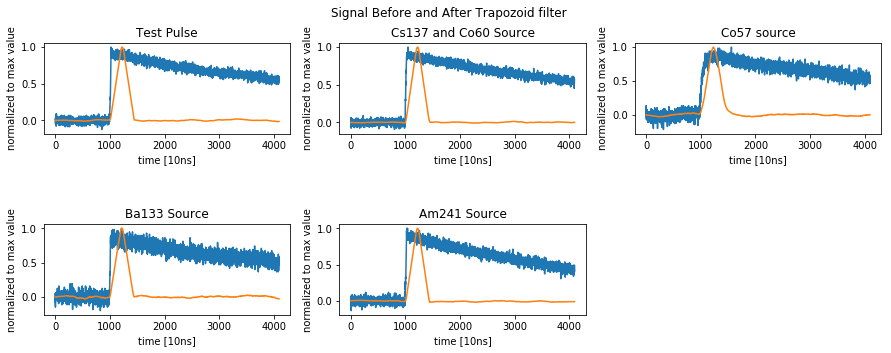

In [11]:
plt.figure(figsize=(15,5))
a_signal1 = baseLineReduction(mysignals1[10][:])
a_signal2 = baseLineReduction(mysignals2[100][:])
a_signal3 = baseLineReduction(mysignals3[1000][:])
a_signal4 = baseLineReduction(mysignals4[10000][:])
a_signal5 = baseLineReduction(mysignals5[50000][:])

plt.subplot(231)
plt.plot(a_signal1[:]/np.amax(a_signal1))
plt.plot(trap_out1[10][:]/np.amax(trap_out1[10][:]))
plt.xlabel('time [10ns]')
plt.ylabel('normalized to max value')
plt.title('Test Pulse')

plt.subplot(232)
plt.plot(a_signal2[:]/np.amax(a_signal2))
plt.plot(trap_out2[100][:]/np.amax(trap_out2[100][:]))
plt.xlabel('time [10ns]')
plt.ylabel('normalized to max value')
plt.title('Cs137 and Co60 Source')

plt.subplot(233)
plt.plot(a_signal3[:]/np.amax(a_signal3))
plt.plot(trap_out3[1000][:]/np.amax(trap_out3[1000][:]))
plt.xlabel('time [10ns]')
plt.ylabel('normalized to max value')
plt.title('Co57 source')

plt.subplot(234)
plt.plot(a_signal4[:]/np.amax(a_signal4))
plt.plot(trap_out4[10000][:]/np.amax(trap_out4[10000][:]))
plt.xlabel('time [10ns]')
plt.ylabel('normalized to max value')
plt.title('Ba133 Source')

plt.subplot(235)
plt.plot(a_signal5[:]/np.amax(a_signal5))
plt.plot(trap_out5[50000][:]/np.amax(trap_out5[50000][:]))
plt.xlabel('time [10ns]')
plt.ylabel('normalized to max value')
plt.title('Am241 Source')

plt.subplots_adjust(hspace = 1, wspace = 0.2)
plt.suptitle('Signal Before and After Trapozoid filter')
plt.savefig('images/5signals.png')

In [14]:
counts1 = []
for j in range(0,len(trap_out1)):
    counts1 = np.append(counts1,np.amax(trap_out1[j]))
    
counts2 = []
for j in range(0,len(trap_out2)):
    counts2 = np.append(counts2,np.amax(trap_out2[j]))
    
counts3 = []
for j in range(0,len(trap_out3)):
    counts3 = np.append(counts3,np.amax(trap_out3[j]))
    
counts4 = []
for j in range(0,len(trap_out4)):
    counts4 = np.append(counts4,np.amax(trap_out4[j]))
    
counts5 = []
for j in range(0,len(trap_out5)):
    counts5 = np.append(counts5,np.amax(trap_out5[j]))

In [15]:
@jit(parallel = True)
def createHist(counts,k,M):
    counts2 = np.trim_zeros(counts)
    counts2 = counts2/((M+1)*k)
    counts3 = counts2[(counts2>0) & (counts2<1e3)]

    yhist, bins_hist = np.histogram(counts3,bins=8196)
    return yhist

k=740.0
M = 5810.8

yhist1 = createHist(counts1,k,M)
yhist2 = createHist(counts2,k,M)
yhist3 = createHist(counts3,k,M)
yhist4 = createHist(counts4,k,M)
yhist5 = createHist(counts5,k,M)



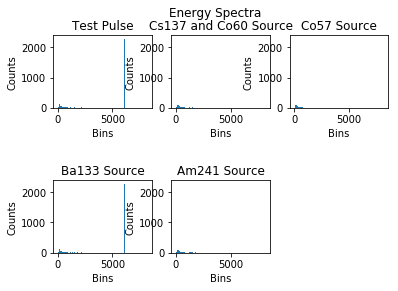

In [16]:
plt.figure()

plt.subplot(231)
plt.bar(range(8196),yhist1, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Test Pulse')

plt.subplot(232)
plt.bar(range(8196),yhist2, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Cs137 and Co60 Source')

plt.subplot(233)
plt.bar(range(8196),yhist3, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Co57 Source')

plt.subplot(234)
plt.bar(range(8196),yhist4, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Ba133 Source')

plt.subplot(235)
plt.bar(range(8196),yhist5, width=1.0)
plt.xlabel('Bins')
plt.ylabel('Counts')
plt.title('Am241 Source')

plt.subplots_adjust(hspace = 1, wspace = 0.2)
plt.suptitle('Energy Spectra')
plt.savefig('images/BinnedData.png')

In [32]:
def gauss(x, a, u, sig): # p[0]==mean, p[1]==stdev
#    return 1.0/(sig*np.sqrt(2.0*np.pi))*np.exp(-(x-u)**2.0/(2.0*sig**2.0))
    return a*np.exp(-(x-u)**2.0/(2.0*sig**2.0))

def FWHM(counts,lower_bound,upper_bound):
    X = range(lower_bound, upper_bound)
    Y = counts[lower_bound:upper_bound]
    # Fit a guassian
    mean = sum(X * Y) / sum(Y)
    sigma = np.sqrt(sum(Y * (X - mean)**2) / sum(Y))
    print(sigma)
    pi = [max(Y), mean,sigma]
    popt, pcov = curve_fit(gauss, X, Y, p0=pi)
    print(popt)
    fit_a, fit_mu, fit_stdev = popt
    plt.plot(X,gauss(X,*popt),'r')
    plt.bar(X,Y, width=1.0)
    plt.xlim(lower_bound,upper_bound)

    return 2*np.sqrt(2*np.log(2))*np.abs(fit_stdev)

82.42840243225876
[  75.02188977 5436.9277346     7.37438301]
17.365344934735415


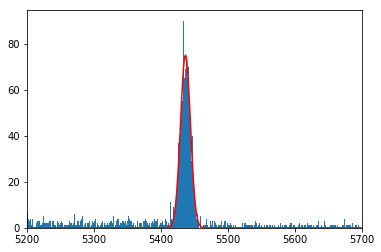

In [35]:

print(FWHM(yhist,5200,5700))